In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px

import folium

from sklearn.preprocessing import MinMaxScaler

import os

In [2]:
def Min_Max_Scaler(df, columns):
    df[columns] = (df[columns] - df[columns].min()) / (df[columns].max() - df[columns].min())
    return df

In [3]:
def Time_Series_Plot(figure, df, date_column, target_column, legend):
    # 시계열 평균 거래금액 그래프
    figure.add_trace(go.Scatter(x=df[date_column], y=df[target_column],
                             mode='lines',
                             name=legend))

In [4]:
deal_df = pd.read_csv('DATA/Apart Deal.csv')
deal_df = deal_df.rename({'지역코드': 'Area code', '법정동':'Dong', '거래일':'Trading day', '아파트':'Apartment', '지번':'Lot number',
                         '전용면적':'Exclusive area', '층':'Floor', '건축년도':'Year of construction', '거래금액':'Transaction amount'},
                        axis='columns')
deal_df.head(3)

C:\Users\JuNoe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



,Area code,Dong,Trading day,Apartment,Lot number,Exclusive area,Floor,Year of construction,Transaction amount
0,31110,학성동,5/30/2020 0:00,남운학성타운,379,135.580,8,1991,26700
1,31110,남외동,1/3/2020 0:00,남외푸르지오1차,506-1,101.600,2,2006,35500
2,31110,남외동,1/3/2020 0:00,에일린의뜰,500,84.992,11,2007,36500


In [5]:
# datetime64 로 type을 변경하면 자동으로 date format 맞춰진다.(시계열 data 전처리)
deal_df = deal_df.astype({'Area code':'int',
                          'Dong':'category',
                          'Trading day':'datetime64',
                          'Apartment':'category',
                          'Lot number':'object',
                          'Exclusive area':'float64',
                          'Floor':'category',
                          'Year of construction':'int',
                          'Transaction amount': 'int'})
deal_df.dtypes

Area code                        int32
Dong                          category
Trading day             datetime64[ns]
Apartment                     category
Lot number                      object
Exclusive area                 float64
Floor                         category
Year of construction             int32
Transaction amount               int32
dtype: object

In [6]:
# 전용면적을 평 단위로 변환
trading_group_pyeong = deal_df
trading_group_pyeong['Exclusive area'] = pd.DataFrame(np.true_divide(deal_df['Exclusive area'], 3.305785))

# 평 당 거래가격 컬럼 생성
trading_group_pyeong['Trans per Pyeong'] = np.true_divide(trading_group_pyeong['Transaction amount'],
                                                          trading_group_pyeong['Exclusive area'])

# 거래일 기준으로 집계 - 평균값
trading_group_pyeong = trading_group_pyeong.groupby('Trading day', as_index=False).mean()

# 불필요한 컬럼 드랍
trading_group_pyeong = trading_group_pyeong.drop(['Area code', 
                                                  'Exclusive area',
#                                                   'Floor', 
                                                  'Year of construction',
                                                  'Transaction amount'], axis=1)
trading_group_pyeong

,Trading day,Trans per Pyeong
0,2015-01-01,999.857017
1,2015-01-02,1004.384202
2,2015-01-03,1172.672387
3,2015-01-04,1089.006130
4,2015-01-05,1036.544871
...,...,...
2284,2021-04-03,1035.413636
2285,2021-04-04,976.026104
2286,2021-04-05,909.763796
2287,2021-04-06,809.463628


In [7]:
# 날짜 별 거래 건 수
trading_group_count = deal_df.groupby('Trading day', as_index=False).count()
trading_group_count = trading_group_count.drop(['Area code',
                                                'Apartment',
                                                'Lot number',
                                                'Dong',
                                                'Exclusive area',
                                                'Floor',
                                                'Year of construction'], axis=1)
trading_group_count.head(3)

,Trading day,Transaction amount,Trans per Pyeong
0,2015-01-01,277,277
1,2015-01-02,1614,1614
2,2015-01-03,1674,1674


In [8]:
# null 값과 중복값을 제외하여 Trading day 컬럼으로 정렬
trading_group_count[trading_group_count['Trading day'].notnull()][['Trading day', 'Transaction amount']].\
drop_duplicates().sort_values(['Trading day'])

# 이미 datetime 형식으로 변함되 있음
# '연-월-일' 형식의 datetime type으로 변환
pd.to_datetime(trading_group_count['Trading day'], format='%y-%m-%d')

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2284   2021-04-03
2285   2021-04-04
2286   2021-04-05
2287   2021-04-06
2288   2021-04-07
Name: Trading day, Length: 2289, dtype: datetime64[ns]

In [9]:
trading_group_count

,Trading day,Transaction amount,Trans per Pyeong
0,2015-01-01,277,277
1,2015-01-02,1614,1614
2,2015-01-03,1674,1674
3,2015-01-04,468,468
4,2015-01-05,2312,2312
...,...,...,...
2284,2021-04-03,584,584
2285,2021-04-04,158,158
2286,2021-04-05,351,351
2287,2021-04-06,184,184


In [10]:
trading_group_pyeong = trading_group_pyeong.drop(trading_group_pyeong.index[0])
trading_group_count = trading_group_count.drop(trading_group_count.index[0])

In [11]:
trading_group_pyeong.set_index('Trading day', inplace=True)
trading_group_count.set_index('Trading day', inplace=True)

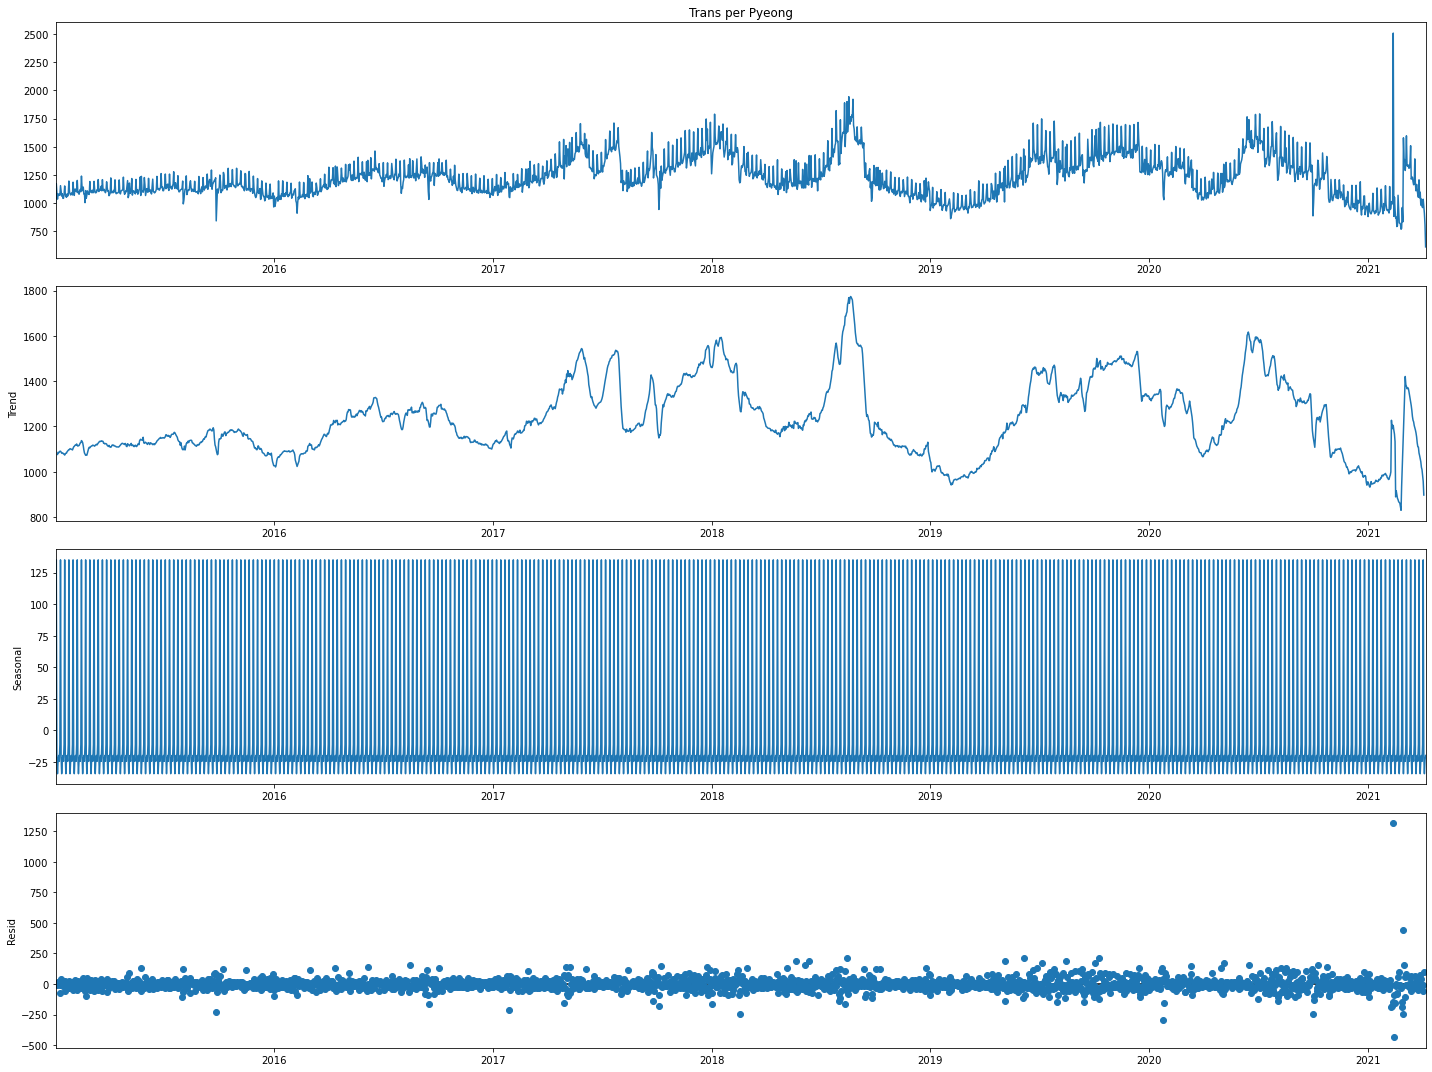

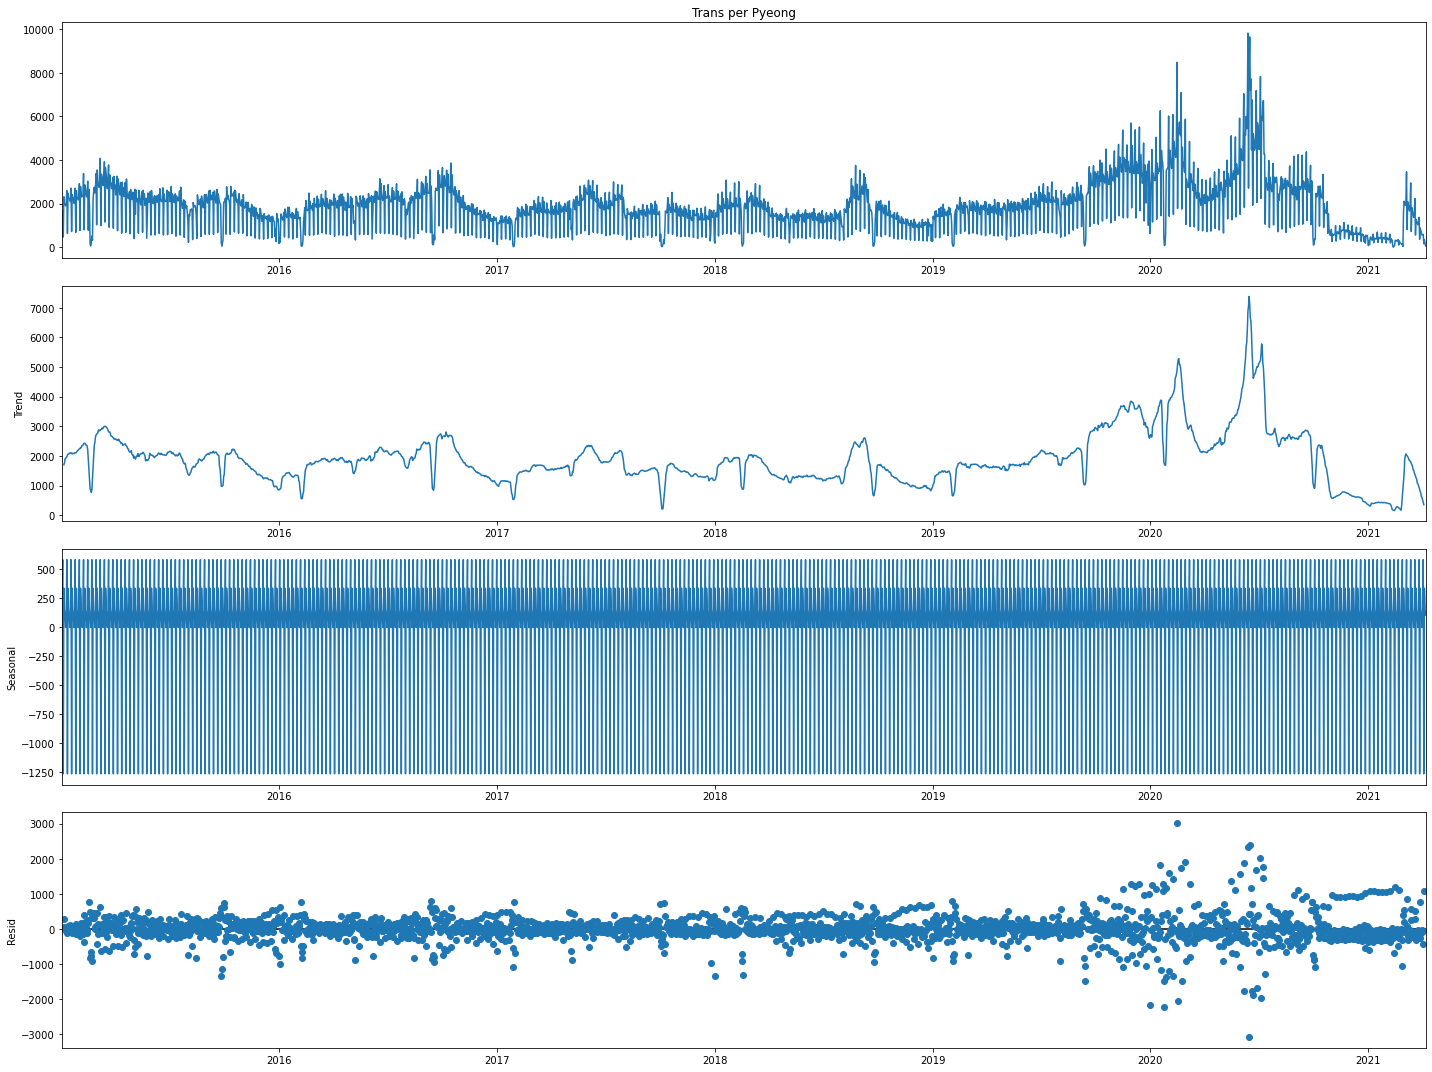

In [38]:
# 시계열 추세 분해 
# https://dsbook.tistory.com/265?category=841791
# https://kanggogo1234.tistory.com/38
# https://rfriend.tistory.com/510?category=675919
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = (20,15)
res_pyeong = seasonal_decompose(trading_group_pyeong['Trans per Pyeong'],model='additive')
res_pyeong.plot()

plt.rcParams['figure.figsize'] = (20,15)
res_count = seasonal_decompose(trading_group_count['Trans per Pyeong'],model='additive')
res_count.plot()
plt.show()


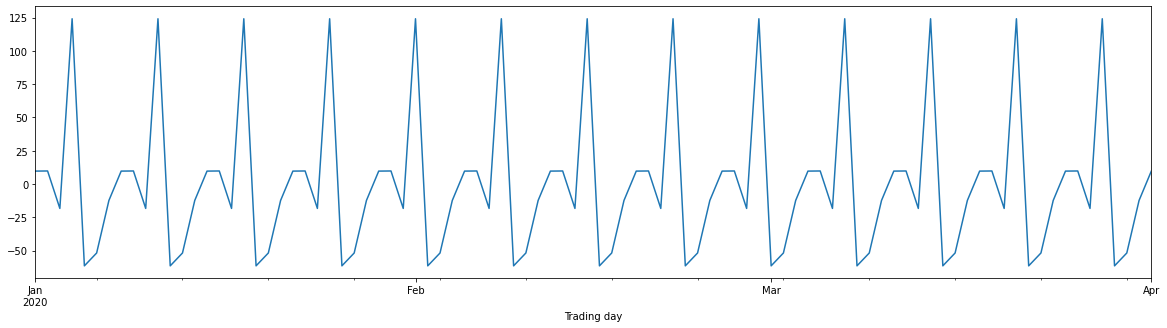

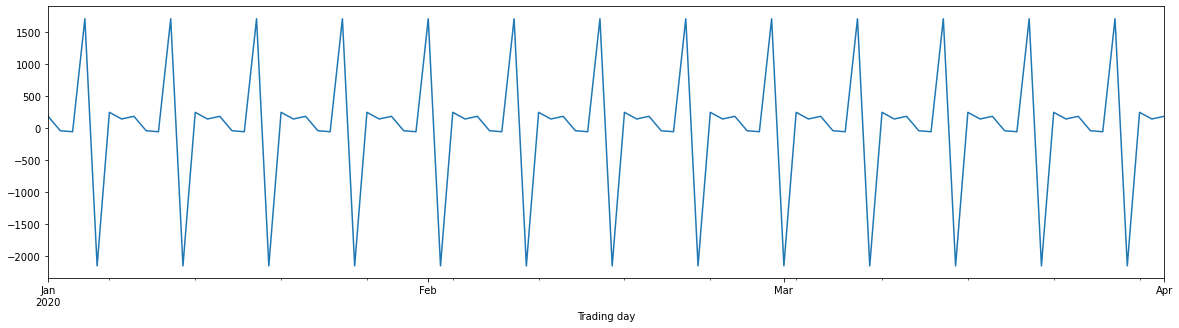

In [30]:
res_pyeong = seasonal_decompose(trading_group_pyeong.loc['2020-01-01':'2020-04-01']['Trans per Pyeong'],model='additive')
plt.figure(figsize=(20, 5))
res_pyeong.seasonal.plot()

res_count = seasonal_decompose(trading_group_count.loc['2020-01-01':'2020-04-01']['Trans per Pyeong'],model='additive')
plt.figure(figsize=(20, 5))
res_count.seasonal.plot()

plt.show()

In [39]:
# pyeong
res_pyeong = res_pyeong.trend
nonseasonal_trading_pyeong = pd.DataFrame()


nonseasonal_trading_pyeong['Trans per Pyeong'] = res_pyeong
nonseasonal_trading_pyeong['Trading day'] = res_pyeong.index
nonseasonal_trading_pyeong.reset_index(drop=True, inplace=True)
# nonseasonal_trading_pyeong

# count
res_count = res_count.trend
nonseasonal_trading_count = pd.DataFrame()


nonseasonal_trading_count['Trans per Pyeong'] = res_count
nonseasonal_trading_count['Trading day'] = res_count.index
nonseasonal_trading_count.reset_index(drop=True, inplace=True)
nonseasonal_trading_count

,Trans per Pyeong,Trading day
0,NaN,2015-01-02
1,NaN,2015-01-03
2,NaN,2015-01-04
3,1701.000000,2015-01-05
4,1760.857143,2015-01-06
...,...,...
2283,435.285714,2021-04-03
2284,350.857143,2021-04-04
2285,NaN,2021-04-05
2286,NaN,2021-04-06


In [40]:
# 날짜컬럼 인덱스로
nonseasonal_trading_pyeong.set_index('Trading day', inplace=True)
# 7일로 이동평균
nonseasonal_mov_avg_pyeong = nonseasonal_trading_pyeong.rolling(window=14).mean()
# 인덱스를 날짜컬럼으로
nonseasonal_mov_avg_pyeong['Trading day'] = nonseasonal_trading_pyeong.index
# nonseasonal_mov_avg_pyeong


# 날짜컬럼 인덱스로
nonseasonal_trading_count.set_index('Trading day', inplace=True)
# 7일로 이동평균
nonseasonal_mov_avg_count = nonseasonal_trading_count.rolling(window=14).mean()
# 인덱스를 날짜컬럼으로
nonseasonal_mov_avg_count['Trading day'] = nonseasonal_trading_count.index
nonseasonal_mov_avg_count

,Trans per Pyeong,Trading day
Trading day,,
2015-01-02,NaN,2015-01-02
2015-01-03,NaN,2015-01-03
2015-01-04,NaN,2015-01-04
2015-01-05,NaN,2015-01-05
2015-01-06,NaN,2015-01-06
...,...,...
2021-04-03,891.193878,2021-04-03
2021-04-04,822.316327,2021-04-04
2021-04-05,NaN,2021-04-05


In [41]:
InterestRate_df = pd.read_csv('DATA/InterestRate.csv', error_bad_lines=False, encoding='CP949' )
InterestRate_df

,Date,InterestRate
0,2015-01-02,2.0
1,2015-01-05,2.0
2,2015-01-06,2.0
3,2015-01-07,2.0
4,2015-01-08,2.0
...,...,...
1540,2021-03-31,0.5
1541,2021-04-01,0.5
1542,2021-04-02,0.5
1543,2021-04-05,0.5


In [42]:
Exchange_df = pd.read_csv('DATA/ExchangeRate.csv')
Exchange_df

,Date,ExchangeRate
0,2015-01-02,"1,097.20"
1,2015-01-05,"1,106.50"
2,2015-01-06,"1,108.00"
3,2015-01-07,"1,098.50"
4,2015-01-08,"1,100.00"
...,...,...
1540,2021-03-31,"1,133.80"
1541,2021-04-01,"1,128.00"
1542,2021-04-02,"1,128.50"
1543,2021-04-05,"1,128.00"


In [43]:
# ExchangeRate컬럼의 타입을 str으로 변환
Exchange_df = Exchange_df.astype({'ExchangeRate':'str'})

# 컬럼길이
Exchange_length = len(Exchange_df)

# 'ExchangeRate'의 ',' 제거
for row in range(Exchange_length):
    Exchange_df.loc[row]['ExchangeRate'] = Exchange_df.loc[row]['ExchangeRate'].replace(',','')

Exchange_df = Exchange_df.astype({'ExchangeRate':'float'})

In [44]:
Min_Max_Scaler(nonseasonal_mov_avg_pyeong, 'Trans per Pyeong')
Min_Max_Scaler(nonseasonal_mov_avg_count, 'Trans per Pyeong')
Min_Max_Scaler(InterestRate_df, 'InterestRate')
Min_Max_Scaler(Exchange_df, 'ExchangeRate')

,Date,ExchangeRate
0,2015-01-02,0.202850
1,2015-01-05,0.247031
2,2015-01-06,0.254157
3,2015-01-07,0.209026
4,2015-01-08,0.216152
...,...,...
1540,2021-03-31,0.376722
1541,2021-04-01,0.349169
1542,2021-04-02,0.351544
1543,2021-04-05,0.349169


In [45]:
fig = go.Figure()
Time_Series_Plot(fig, nonseasonal_mov_avg_count, 'Trading day', 'Trans per Pyeong', 'Trans counts')
Time_Series_Plot(fig, nonseasonal_mov_avg_pyeong, 'Trading day', 'Trans per Pyeong', 'Trans per Pyeong')
fig.show()

In [46]:
fig = go.Figure()
Time_Series_Plot(fig, nonseasonal_mov_avg_count, 'Trading day', 'Trans per Pyeong', 'Trans per Pyeong')
Time_Series_Plot(fig, Exchange_df, 'Date', 'ExchangeRate', 'Exchange Rate')
fig.show()

In [47]:
fig = go.Figure()
# Time_Series_Plot(fig, nonseasonal_mov_avg_pyeong, 'Trading day', 'Trans per Pyeong', 'Trans per Pyeong')

Time_Series_Plot(fig, nonseasonal_mov_avg_count, 'Trading day', 'Trans per Pyeong', 'Trans counts')

Time_Series_Plot(fig, InterestRate_df, 'Date', 'InterestRate', 'Interest Rate')

fig.show()

In [48]:
fig = go.Figure()
Time_Series_Plot(fig, nonseasonal_mov_avg_pyeong, 'Trading day', 'Trans per Pyeong', 'Trans per Pyeong')
Time_Series_Plot(fig, Exchange_df, 'Date', 'ExchangeRate', 'Exchange Rate')
Time_Series_Plot(fig, nonseasonal_mov_avg_count, 'Trading day', 'Trans per Pyeong', 'Trans counts')
Time_Series_Plot(fig, InterestRate_df, 'Date', 'InterestRate', 'Interest Rate')
fig.show()

In [24]:
CLI = pd.read_csv("DATA/CLI.csv")
CLI

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,CHN,CLI,AMPLITUD,LTRENDIDX,M,2012-03,99.53799,NaN
1,CHN,CLI,AMPLITUD,LTRENDIDX,M,2012-04,99.59992,NaN
2,CHN,CLI,AMPLITUD,LTRENDIDX,M,2012-05,99.67764,NaN
3,CHN,CLI,AMPLITUD,LTRENDIDX,M,2012-06,99.76327,NaN
4,CHN,CLI,AMPLITUD,LTRENDIDX,M,2012-07,99.85445,NaN
...,...,...,...,...,...,...,...,...
439,USA,CLI,AMPLITUD,LTRENDIDX,M,2021-01,99.48358,NaN
440,USA,CLI,AMPLITUD,LTRENDIDX,M,2021-02,99.83427,NaN
441,USA,CLI,AMPLITUD,LTRENDIDX,M,2021-03,100.15710,NaN
442,USA,CLI,AMPLITUD,LTRENDIDX,M,2021-04,100.43180,NaN


In [25]:
CLI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LOCATION    444 non-null    object 
 1   INDICATOR   444 non-null    object 
 2   SUBJECT     444 non-null    object 
 3   MEASURE     444 non-null    object 
 4   FREQUENCY   444 non-null    object 
 5   TIME        444 non-null    object 
 6   Value       444 non-null    float64
 7   Flag Codes  0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 27.9+ KB


In [26]:
# CHN, OECD, USA 경기선행지수
CHN_index = CLI['LOCATION'] == "CHN"
CLI_CHN = CLI.loc[CHN_index]
OECD_index = CLI['LOCATION'] == "OECD"
CLI_OECD = CLI.loc[OECD_index]
USA_index = CLI['LOCATION'] == "USA"
CLI_USA = CLI.loc[USA_index]

In [27]:
# 경기선행지수 
fig = go.Figure()
Time_Series_Plot(fig, CLI_CHN, 'TIME', 'Value', 'CHINA')
Time_Series_Plot(fig, CLI_OECD, 'TIME', 'Value', 'OECD')
Time_Series_Plot(fig, CLI_USA, 'TIME', 'Value', 'USA')
fig.show()

In [49]:
deal_df = pd.read_csv('DATA/Apart Deal.csv')
deal_df = deal_df.rename({'지역코드': 'Area code', '법정동':'Dong', '거래일':'Trading day', '아파트':'Apartment', '지번':'Lot number',
                         '전용면적':'Exclusive area', '층':'Floor', '건축년도':'Year of construction', '거래금액':'Transaction amount'},
                        axis='columns')
deal_df.head(3)

C:\Users\JuNoe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning:

Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.



,Area code,Dong,Trading day,Apartment,Lot number,Exclusive area,Floor,Year of construction,Transaction amount
0,31110,학성동,5/30/2020 0:00,남운학성타운,379,135.580,8,1991,26700
1,31110,남외동,1/3/2020 0:00,남외푸르지오1차,506-1,101.600,2,2006,35500
2,31110,남외동,1/3/2020 0:00,에일린의뜰,500,84.992,11,2007,36500


In [50]:
# datetime64 로 type을 변경하면 자동으로 date format 맞춰진다.(시계열 data 전처리)
deal_df = deal_df.astype({'Area code':'int',
                          'Dong':'category',
                          'Trading day':'datetime64',
                          'Apartment':'category',
                          'Lot number':'object',
                          'Exclusive area':'float64',
                          'Floor':'category',
                          'Year of construction':'int',
                          'Transaction amount': 'int'})
deal_df.dtypes

Area code                        int32
Dong                          category
Trading day             datetime64[ns]
Apartment                     category
Lot number                      object
Exclusive area                 float64
Floor                         category
Year of construction             int32
Transaction amount               int32
dtype: object

In [ ]:
import re
 p = re.search('\w','1')

In [51]:
seoul_df = deal_df.loc[deal_df['Area code']==1????]

SyntaxError: invalid syntax (<ipython-input-51-a965985a4057>, line 1)

In [ ]:
# 전용면적을 평 단위로 변환
trading_group_pyeong = deal_df
trading_group_pyeong['Exclusive area'] = pd.DataFrame(np.true_divide(deal_df['Exclusive area'], 3.305785))

# 평 당 거래가격 컬럼 생성
trading_group_pyeong['Trans per Pyeong'] = np.true_divide(trading_group_pyeong['Transaction amount'],
                                                          trading_group_pyeong['Exclusive area'])

# 거래일 기준으로 집계 - 평균값
trading_group_pyeong = trading_group_pyeong.groupby('Trading day', as_index=False).mean()

# 불필요한 컬럼 드랍
trading_group_pyeong = trading_group_pyeong.drop(['Area code', 
                                                  'Exclusive area',
#                                                   'Floor', 
                                                  'Year of construction',
                                                  'Transaction amount'], axis=1)
trading_group_pyeong